In [1]:
#pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm import tqdm

#other libraries
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [26]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

batch_size = 4

root_dir = '/mnt/storage/Datasets/CIFAR10' #make sure to change it to your own path

train_set = datasets.CIFAR10(root=root_dir, train=True, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

test_set = datasets.CIFAR10(root=root_dir, train=False, download=True, transform=transform)

test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
#test the data loader
for image, labels in train_loader:
    print(image.shape)
    print(labels)
    break

torch.Size([4, 3, 32, 32])
tensor([2, 7, 7, 2])


In [50]:
class AutoEncoder(nn.Module):
    def __init__(self, hidden_dim=64, latent_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, hidden_dim//2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(hidden_dim//2, hidden_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(hidden_dim, latent_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, hidden_dim, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_dim, hidden_dim//2, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_dim//2, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [51]:
from torchvision.models import vit_b_16

vit_model = vit_b_16(weights='ViT_B_16_Weights.IMAGENET1K_V1')

In [52]:
vit_model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [62]:
auto_encoder = AutoEncoder()

auto_encoder.to(device)

loss_fn = nn.MSELoss()

optimizer = Adam(auto_encoder.parameters(), lr=1e-5)

In [63]:


#training process

epochs = 10
outputs = []

loss_list = []
 

for epoch in range(epochs):
    loss_avg = 0
    for i, data in enumerate(tqdm(train_loader)):
        
        (images, _) = data
        images = images.to(device)
        # print(images.shape)
        
        recon = auto_encoder(images)
        # print(recon.shape)
        
        loss = loss_fn(recon, images)
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_avg += loss.item()
    loss_avg = loss_avg / len(train_loader)
    loss_list.append(loss_avg)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss_avg:.4f}')
    outputs.append((epoch, images, recon))
        

100%|██████████| 12500/12500 [00:51<00:00, 242.85it/s]


Epoch [1/10], Loss: 0.0276


100%|██████████| 12500/12500 [00:50<00:00, 249.28it/s]


Epoch [2/10], Loss: 0.0167


100%|██████████| 12500/12500 [00:51<00:00, 241.91it/s]


Epoch [3/10], Loss: 0.0131


100%|██████████| 12500/12500 [00:55<00:00, 224.70it/s]


Epoch [4/10], Loss: 0.0117


100%|██████████| 12500/12500 [00:51<00:00, 241.63it/s]


Epoch [5/10], Loss: 0.0108


100%|██████████| 12500/12500 [00:51<00:00, 241.03it/s]


Epoch [6/10], Loss: 0.0101


100%|██████████| 12500/12500 [00:54<00:00, 227.68it/s]


Epoch [7/10], Loss: 0.0096


100%|██████████| 12500/12500 [00:53<00:00, 235.63it/s]


Epoch [8/10], Loss: 0.0092


100%|██████████| 12500/12500 [00:53<00:00, 233.19it/s]


Epoch [9/10], Loss: 0.0088


100%|██████████| 12500/12500 [00:56<00:00, 221.65it/s]

Epoch [10/10], Loss: 0.0085


torch.Size([4, 3, 32, 32])


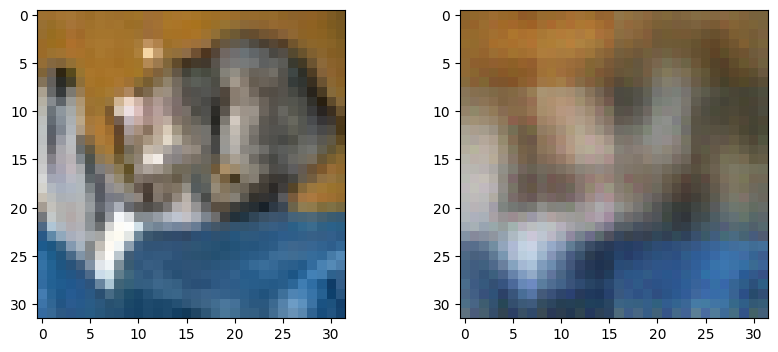

In [64]:
#model testing

for i, data in enumerate(test_loader):
    (images, _) = data
    images = images.to(device)
    print(images.shape)
    # images_reshaped = images.reshape(-1, 32*32)
    recon = auto_encoder(images).to(device)
    break
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(images[0].permute(1, 2, 0).cpu().detach().numpy())
ax[1].imshow(recon[0].permute(1, 2, 0).cpu().detach().numpy())
